In [126]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
#from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import openpyxl
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler

## Read Data Set 

In [127]:
data=pd.read_excel('final_df.xlsx',header=0)

In [128]:
data=data.set_index('Date')

In [129]:
data.head()

,Average Temperature,Mean Watertemperature,Mean Salinity,Mean Conductivity,Mean Chlorofyl
Date,,,,,
2021-04-03,7.1,9.778000,0.473533,677.460000,6.628758
2021-04-04,6.1,9.778000,0.473533,677.460000,6.628758
2021-04-05,4.4,9.778000,0.473533,677.460000,6.628758
2021-04-06,1.9,9.778000,0.473533,677.460000,6.628758
2021-04-07,2.8,9.214583,0.464062,653.989583,6.435069


# First Regression Approach with an MultiLayerPerceptron (Requires Data Transformation in order to make the df supervised)

## Isolate Mean Conductivity Feature 

In [130]:
only_mean_conductivity=data['Mean Conductivity'].to_frame(name='Mean Conductivity')

In [131]:
only_mean_conductivity.head()

,Mean Conductivity
Date,
2021-04-03,677.460000
2021-04-04,677.460000
2021-04-05,677.460000
2021-04-06,677.460000
2021-04-07,653.989583


## Standarization Using Min Max Scaler 

In [132]:
df= only_mean_conductivity.copy()
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled  = min_max_scaler.fit_transform(np.reshape(df['Mean Conductivity'].values, (df.shape[0], 1)))
df_scaled  = pd.DataFrame(data=df_scaled , columns=['Mean Conductivity'])

In [133]:
df_scaled.head()

,Mean Conductivity
0,0.569146
1,0.569146
2,0.569146
3,0.569146
4,0.523979


# Make data Supervised: Use past 90 registrations (days in our case) to predict the next one.

## Make each input a set of the 90 previous registrations.
## Make the target the next Mean conductibity Value. (Next Day's Value)

In [134]:
def timeseries_to_supervised(df, n_in, n_out):
   agg = pd.DataFrame()

   for i in range(n_in, 0, -1):
      df_shifted = df.shift(i).copy()
      df_shifted.rename(columns=lambda x: ('%s(t-%d)' % (x, i)), inplace=True)
      agg = pd.concat([agg, df_shifted], axis=1)

   for i in range(0, n_out):
      df_shifted = df.shift(-i).copy()
      if i == 0:
         df_shifted.rename(columns=lambda x: ('%s(t)' % (x)), inplace=True)
      else:
         df_shifted.rename(columns=lambda x: ('%s(t+%d)' % (x, i)), inplace=True)
      agg = pd.concat([agg, df_shifted], axis=1)
   agg.dropna(inplace=True)
   return agg

In [135]:
n_in = 90 #Timeseries consists of 90 input steps.
n_out = 1
sdf = timeseries_to_supervised(df_scaled, n_in, n_out)

In [136]:
sdf.head()

,Mean Conductivity(t-90),Mean Conductivity(t-89),Mean Conductivity(t-88),Mean Conductivity(t-87),Mean Conductivity(t-86),Mean Conductivity(t-85),Mean Conductivity(t-84),Mean Conductivity(t-83),Mean Conductivity(t-82),Mean Conductivity(t-81),...,Mean Conductivity(t-9),Mean Conductivity(t-8),Mean Conductivity(t-7),Mean Conductivity(t-6),Mean Conductivity(t-5),Mean Conductivity(t-4),Mean Conductivity(t-3),Mean Conductivity(t-2),Mean Conductivity(t-1),Mean Conductivity(t)
90,0.569146,0.569146,0.569146,0.569146,0.523979,0.515446,0.528569,0.560122,0.586737,0.581592,...,0.759818,0.718429,0.654093,0.592878,0.534055,0.511477,0.563824,0.553841,0.532605,0.544633
91,0.569146,0.569146,0.569146,0.523979,0.515446,0.528569,0.560122,0.586737,0.581592,0.536661,...,0.718429,0.654093,0.592878,0.534055,0.511477,0.563824,0.553841,0.532605,0.544633,0.608701
92,0.569146,0.569146,0.523979,0.515446,0.528569,0.560122,0.586737,0.581592,0.536661,0.581605,...,0.654093,0.592878,0.534055,0.511477,0.563824,0.553841,0.532605,0.544633,0.608701,0.615965
93,0.569146,0.523979,0.515446,0.528569,0.560122,0.586737,0.581592,0.536661,0.581605,0.587893,...,0.592878,0.534055,0.511477,0.563824,0.553841,0.532605,0.544633,0.608701,0.615965,0.534022
94,0.523979,0.515446,0.528569,0.560122,0.586737,0.581592,0.536661,0.581605,0.587893,0.542722,...,0.534055,0.511477,0.563824,0.553841,0.532605,0.544633,0.608701,0.615965,0.534022,0.440419


In [137]:
X, y = sdf[[('Mean Conductivity(t-%d)' % i) for i in range(90, 0, -1)]].values, sdf['Mean Conductivity(t)'].values #seperate X as the 90 steps of the timeseries and y as the predicted value(target).

## Seperate the dataset for Training and Testing

In [138]:
len_data = X.shape[0]
print("Data size: %d" % len_data)
train_size = int(len_data * .7)# 70% for training and 30% for testing
print ("Train  data size: %d" % train_size)
print ("Test data size: %d" % (len_data - train_size))

xtr, ytr = X[:train_size, :], y[:train_size]
xte, yte = X[train_size:, :], y[train_size:]
print(xtr.shape, ytr.shape)
print(xte.shape, yte.shape)

Data size: 276
Train  data size: 193
Test data size: 83
(193, 90) (193,)
(83, 90) (83,)


## Set up the model

In [139]:
batch_size = 1 #1
model = Sequential()

model.add(Dense(units=50, input_dim=xtr.shape[1], activation="relu"))#input dim is 4 as the timeseries steps.
model.add(Dense(50, activation="relu"))# linear activation functios was used as well
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 50)                4550      
_________________________________________________________________
dense_12 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 7,151
Trainable params: 7,151
Non-trainable params: 0
_________________________________________________________________


## Training the MLP 

In [140]:
model.fit(xtr,ytr, epochs=50, batch_size=batch_size, verbose=2)

Epoch 1/50
193/193 - 0s - loss: 0.0442
Epoch 2/50
193/193 - 0s - loss: 0.0165
Epoch 3/50
193/193 - 0s - loss: 0.0147
Epoch 4/50
193/193 - 0s - loss: 0.0119
Epoch 5/50
193/193 - 0s - loss: 0.0107
Epoch 6/50
193/193 - 0s - loss: 0.0115
Epoch 7/50
193/193 - 0s - loss: 0.0090
Epoch 8/50
193/193 - 0s - loss: 0.0077
Epoch 9/50
193/193 - 0s - loss: 0.0105
Epoch 10/50
193/193 - 0s - loss: 0.0072
Epoch 11/50
193/193 - 0s - loss: 0.0070
Epoch 12/50
193/193 - 0s - loss: 0.0073
Epoch 13/50
193/193 - 0s - loss: 0.0056
Epoch 14/50
193/193 - 0s - loss: 0.0057
Epoch 15/50
193/193 - 0s - loss: 0.0077
Epoch 16/50
193/193 - 0s - loss: 0.0063
Epoch 17/50
193/193 - 0s - loss: 0.0049
Epoch 18/50
193/193 - 0s - loss: 0.0048
Epoch 19/50
193/193 - 0s - loss: 0.0063
Epoch 20/50
193/193 - 0s - loss: 0.0049
Epoch 21/50
193/193 - 0s - loss: 0.0057
Epoch 22/50
193/193 - 0s - loss: 0.0057
Epoch 23/50
193/193 - 0s - loss: 0.0048
Epoch 24/50
193/193 - 0s - loss: 0.0062
Epoch 25/50
193/193 - 0s - loss: 0.0046
Epoch 26/

## Time for Testing 

In [141]:
trainPredict = model.predict(xtr, batch_size=batch_size)
testPredict = model.predict(xte, batch_size=batch_size)

In [142]:
ytr2d = np.reshape(ytr, (ytr.shape[0], 1))
yte2d = np.reshape(yte, (yte.shape[0], 1))

## Inverse Standarization in order to get true predictions 

In [143]:
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform(ytr2d)
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform(yte2d)

## Evaluate Regression Performance 

In [144]:
print("Test MSE: ", mean_squared_error(testY, testPredict))
print("Test MAE: ", sum(abs(testY-testPredict))/testY.shape[0])
print("Test R2: ", r2_score(testY, testPredict))

Test MSE:  3985.5162827312956
Test MAE:  [55.68362051]
Test R2:  0.5243689732924559


## Display the performance during testing. 

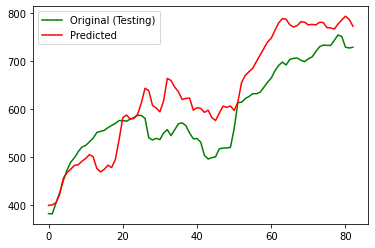

In [148]:
original = testY
predicted = testPredict
index = range(0, original.shape[0])
plt.plot(index,original, 'g',label='Original (Testing)')
plt.plot(index,predicted, 'r',label='Predicted')
plt.legend()
plt.show()

## Forecast Future Mean Conductivity Values

In [152]:
dates=data.reset_index().Date

In [153]:
#Label the Dates
n_past = 90
n_days_for_testing_prediction=150  #predict the next 60 days (150 total dates - 90 first known days)
predict_period_dates = pd.date_range(list(dates)[-n_past], periods=n_days_for_testing_prediction,freq='D').tolist()


In [154]:
forecast = model.predict(X[-n_days_for_testing_prediction:], batch_size=batch_size)#predict

In [155]:
forecasts = min_max_scaler.inverse_transform(forecast)#inverse

In [156]:
forecasts=np.squeeze(forecasts)#reshape

In [157]:
#give the right Date labels
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Mean Conductivity Predicted':forecasts})

In [158]:
df_forecast=df_forecast.iloc[90:]

In [159]:
len(df_forecast)

60

In [48]:
forecasts=pd.concat([data.reset_index(),df_forecast])

In [49]:
forecasts['Date']=pd.to_datetime(forecasts['Date'])

## Display the Forecasts 

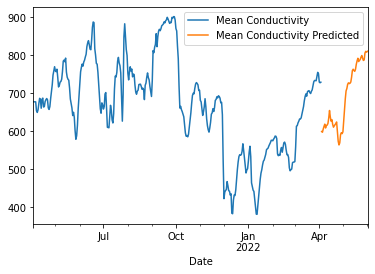

In [50]:
%matplotlib inline
forecasts.plot( 'Date' , ['Mean Conductivity','Mean Conductivity Predicted'] )
plt.show()

## Approach 2: Using  a LSTM (RNN) ,Splitting the Data for Training and Testing 

In [160]:
data=data.reset_index()

In [161]:
df=data.iloc[:, [1,2,3,4,5]] #Get rid of the Date

In [162]:
len_data = df.shape[0]
train_size = int(len_data * .7)# 70% for training and 30% for testing

In [163]:
train_size

256

In [174]:
xtr= df[:train_size]
xte= df[train_size:]

In [175]:
dates=pd.DataFrame(data['Date']) #keep the dates for Display and Evaluation Purposes
dates=data['Date']
train_dates = dates[:train_size]
test_dates = dates[train_size:]

# Standarization Using Standard Scaler 

In [177]:
standard_scaler = StandardScaler()
standard_scaler  = standard_scaler .fit(xtr)
df_for_training_scaled = standard_scaler.transform(xtr)
df_for_testing_scaled = standard_scaler.transform(xte)
data_scaled=standard_scaler.transform(data.drop(columns={'Date'}))

## Use past 30 Values to Predict the Next One

In [181]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 30  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:xtr.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (226, 30, 5).
trainY shape == (226, 1).


## Build The model 

In [186]:
model2 = Sequential()
model2.add(LSTM(32, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model2.add(LSTM(10, activation='relu', return_sequences=False))
model2.add(Dense(trainY.shape[1]))

model2.compile(optimizer='adam', loss='mse')
model2.summary()


# fit the model
history = model2.fit(trainX, trainY, epochs=45, batch_size=8,verbose=1)


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 30, 32)            4864      
_________________________________________________________________
lstm_11 (LSTM)               (None, 10)                1720      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 6,595
Trainable params: 6,595
Non-trainable params: 0
_________________________________________________________________
Epoch 1/45
29/29 [==============================] - 0s 8ms/step - loss: 0.6066
Epoch 2/45
29/29 [==============================] - 0s 8ms/step - loss: 0.2656
Epoch 3/45
29/29 [==============================] - 0s 7ms/step - loss: 0.2018
Epoch 4/45
29/29 [==============================] - 0s 8ms/step - loss: 0.1854
Epoch 5/45
29/29 [==============================] - 0s 7ms/step - 

## Time For Testing 

In [202]:
testX = []
testY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 30  # Using the past 15 days to predict the next one.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_testing_scaled) - n_future +1):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing_scaled.shape[1]])
    testY.append(df_for_testing_scaled[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (80, 30, 5).
testY shape == (80, 1).


In [207]:
#labeling
n_past = 110
n_days_for_testing_prediction=110  #Predict the same dates as our testing sample in order to compare (80 days in the testing sample +30 that we need for very first predictions =110 dates we need)
predict_period_dates = pd.date_range(list(test_dates)[-n_past], periods=n_days_for_testing_prediction,freq='D').tolist()



In [209]:
prediction = model2.predict(testX[-n_days_for_testing_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

In [211]:
prediction_copies = np.repeat(prediction, xte.shape[1], axis=-1) #for reshape puroposes (copye and delete)
y_pred_future = standard_scaler.inverse_transform(prediction_copies)[:,3] #3 refers to the Mean Conductivity

In [219]:
forecast_dates_for_testing = []
for time_i in predict_period_dates:
    forecast_dates_for_testing.append(time_i.date())
forecast_dates=pd.DataFrame({'Date':np.array(forecast_dates_for_testing)})
forecast_dates=forecast_dates.iloc[30:]#delete first 30 dates as they are the 30 previoues needed for the prediction
df_forecast_testing = pd.DataFrame({'Date':np.array(forecast_dates['Date']), 'Mean Conductivity Predicted':y_pred_future})
df_forecast_testing['Date']=pd.to_datetime(df_forecast_testing['Date'])
df_xte_testing = pd.DataFrame({'Date':np.array(forecast_dates['Date']), 'Mean Conductivity':xte['Mean Conductivity'].iloc[30:]})
df_xte_testing['Date']=pd.to_datetime(df_xte_testing['Date'])

In [221]:
testing_results=pd.merge(df_forecast_testing,df_xte_testing,left_on=['Date'],right_on=['Date'],how='left',indicator=True)

##  Evaluate Regression performance using R2 

In [222]:
print("Test R2: ", r2_score(testing_results['Mean Conductivity'], testing_results['Mean Conductivity Predicted']))

Test R2:  0.09747049726493662


## Display Results 

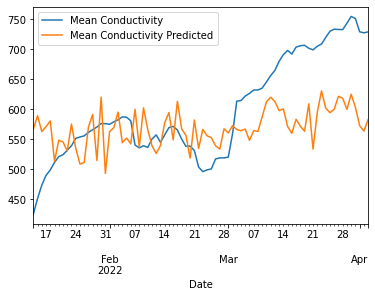

In [223]:
%matplotlib inline
testing_results.plot( 'Date' , ['Mean Conductivity','Mean Conductivity Predicted'] )
plt.show()

## Approach 3: Using an LSTM (RNN) with the difference that we use the whole df for the testing 

In [224]:
dates = pd.to_datetime(data['Date'])

In [225]:
df_for_training =data.iloc[:, [1,2,3,4,5]]

In [226]:
df_for_training

,Average Temperature,Mean Watertemperature,Mean Salinity,Mean Conductivity,Mean Chlorofyl
0,7.1,9.778000,0.473533,677.460000,6.628758
1,6.1,9.778000,0.473533,677.460000,6.628758
2,4.4,9.778000,0.473533,677.460000,6.628758
3,1.9,9.778000,0.473533,677.460000,6.628758
4,2.8,9.214583,0.464062,653.989583,6.435069
...,...,...,...,...,...
361,8.7,12.210069,0.496944,754.850694,10.620833
362,5.0,11.976736,0.497882,751.381944,10.678819
363,2.3,11.142708,0.492986,729.250000,9.947222
364,3.0,10.216319,0.503681,727.534722,9.950347


# Standarization again

In [85]:
scaler = standard_scaler.fit(df_for_training)
df_for_training_scaled = standard_scaler.transform(df_for_training)

In [229]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 90  # Number of past days we want to use to predict the future.

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (166, 90, 5).
trainY shape == (166, 1).


## Build the model

In [230]:
model3 = Sequential()
model3.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model3.add(LSTM(32, activation='relu', return_sequences=False))
model3.add(Dense(trainY.shape[1]))

model3.compile(optimizer='adam', loss='mse')
model3.summary()


# fit the model
history = model3.fit(trainX, trainY, epochs=65, batch_size=8, verbose=1)


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 90, 64)            17920     
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/65
21/21 [==============================] - 1s 26ms/step - loss: 0.5578
Epoch 2/65
21/21 [==============================] - 1s 25ms/step - loss: 0.2105
Epoch 3/65
21/21 [==============================] - 1s 25ms/step - loss: 0.1703
Epoch 4/65
21/21 [==============================] - 1s 25ms/step - loss: 0.1343
Epoch 5/65
21/21 [==============================] - 1s 25ms

In [231]:
n_past = 90
n_days_for_prediction=150  #Predict the next 60 days using the previous 90

predict_period_dates = pd.date_range(list(dates)[-n_past], periods=n_days_for_prediction, freq='D').tolist()

In [234]:
trainX[-n_days_for_prediction:].shape

(150, 90, 5)

In [233]:
prediction = model3.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

In [235]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)#reshape
y_pred_future = scaler.inverse_transform(prediction_copies)[:,3]# inverse standarization

In [253]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Mean Conductivity Predicted':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [254]:
len(df_forecast)

150

## Keep only the days tha was used for the prediction, in order to test and compare

In [258]:
testing_results=pd.merge(df_forecast,data,left_on=['Date'],right_on=['Date'],how='left',indicator=True)

In [259]:
testing=testing_results.dropna()

In [260]:
testing

,Date,Mean Conductivity Predicted,Average Temperature,Mean Watertemperature,Mean Salinity,Mean Conductivity,Mean Chlorofyl,_merge
0,2022-01-04,813.081482,7.0,9.620486,0.371042,533.336806,6.863889,both
1,2022-01-05,825.382751,4.2,8.960417,0.327431,464.388889,8.951736,both
2,2022-01-06,830.854553,3.8,8.195486,0.327222,455.434028,8.392014,both
3,2022-01-07,832.175110,4.4,7.551042,0.325694,445.194444,7.130208,both
4,2022-01-08,829.350708,4.2,6.944444,0.328437,442.017361,6.804861,both
...,...,...,...,...,...,...,...,...
85,2022-03-30,608.356995,8.7,12.210069,0.496944,754.850694,10.620833,both
86,2022-03-31,613.942566,5.0,11.976736,0.497882,751.381944,10.678819,both
87,2022-04-01,619.469666,2.3,11.142708,0.492986,729.250000,9.947222,both
88,2022-04-02,624.263977,3.0,10.216319,0.503681,727.534722,9.950347,both


In [261]:
print("Test R2: ", r2_score(testing['Mean Conductivity'], testing['Mean Conductivity Predicted']))

Test R2:  -4.4041145954259004


## Display both Testing values (where the lines coexist) and the forecasted values (only orange line)

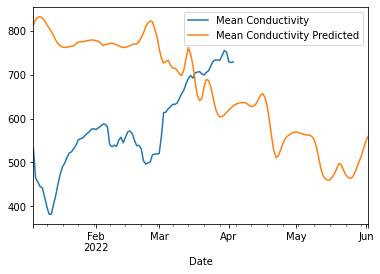

In [262]:
%matplotlib inline
testing_results.plot( 'Date' , ['Mean Conductivity','Mean Conductivity Predicted'] )
plt.show()